In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
pd.options.display.max_rows=10
%matplotlib inline

In [62]:
# %load network-benchmark
#!/usr/bin/env python3

import glob
import io

import pandas as pd
import numpy as np


TEST_RESULT_FILES_PATTERN = \
    "/Users/esteele/tmp/wifi-test/root/wifi-test-results/test-run-{0}/*.csv"


def get_test_run_results(test_run_id):
    test_result_files_glob = TEST_RESULT_FILES_PATTERN.format(test_run_id)
    result_sio = io.StringIO()
    for csv in glob.iglob(test_result_files_glob):
        with open(csv) as f:
            result_sio.write(f.read())

    # Prime for reading
    result_sio.seek(0)
    return result_sio


def get_dataframe_from_test_run(test_run_id):
    raw_run_data = get_test_run_results(test_run_id)
    summary_data = pd.read_csv(raw_run_data,
                               comment="#",
                               names=["client_id",
                                      "timestamp",
                                      "bytes_per_sec"])
    # Create a time_offset column
    summary_data["time_offset"] = \
        summary_data["timestamp"] - min(summary_data["timestamp"])
    return summary_data


def get_tick_labels(min_value, max_value, labels_count):
    return list(range(int(np.floor(min_value)),
                      int(np.ceil(max_value)),
                      int(max_value/labels_count))) + \
            [max_value]


def show_run_df_as_line_graph(df, title):
    pivot_df = df.pivot(index="time_offset",
                        columns="client_id",
                        values="bytes_per_sec")
    ax = pivot_df.plot(figsize=(10, 10))
    ax.set_xlabel("Elapsed time (sec)")
    ax.set_ylabel("Throughput (bytes/sec)")
    ax.axhline(y=250000,
               color='0.75',
               linestyle="--")
    ax.annotate(" 480p bitrate",
                (max(df["time_offset"]), 250000))
    ax.set_title(title)


def show_run_df_as_boxplot(df, title):
    labels = get_tick_labels(min(df["time_offset"]),
                             max(df["time_offset"]),
                             10)
    ax2 = df.boxplot(column="bytes_per_sec",
                     by="time_offset",
                     figsize=(10, 10))
    ax2.set_xlabel("Elapsed time (sec)")
    ax2.grid()
    ax2.set_xticks(labels)
    ax2.set_xticklabels(labels)
    ax2.set_ylabel("Throughput (bytes/sec)")
    ax2.axhline(y=250000, color='0.75', linestyle="--")
    ax2.annotate("       480p bitrate", (max(df["time_offset"]), 250000))
    ax2.set_title(title)


In [63]:
run_id = 675426226    # 2 good clients, 15 streams
run_id2 = 544558453   # 2 good clients, 20 streams
run_id = 1268137335   # 2 good clients, 14 streams + 1 bad client w/ 1 stream
run_id = 552561623   # 2 good clients, 14 streams + 1 bad client w/ 1 stream. Synced
summary_data = get_dataframe_from_test_run(run_id)
summary_data.head()

,client_id,timestamp,bytes_per_sec,time_offset
0,client1.wifi-test_24618,1495833666,320331,1
1,client1.wifi-test_24618,1495833667,327680,2
2,client1.wifi-test_24618,1495833668,262144,3
3,client1.wifi-test_24618,1495833669,327680,4
4,client1.wifi-test_24618,1495833670,327680,5


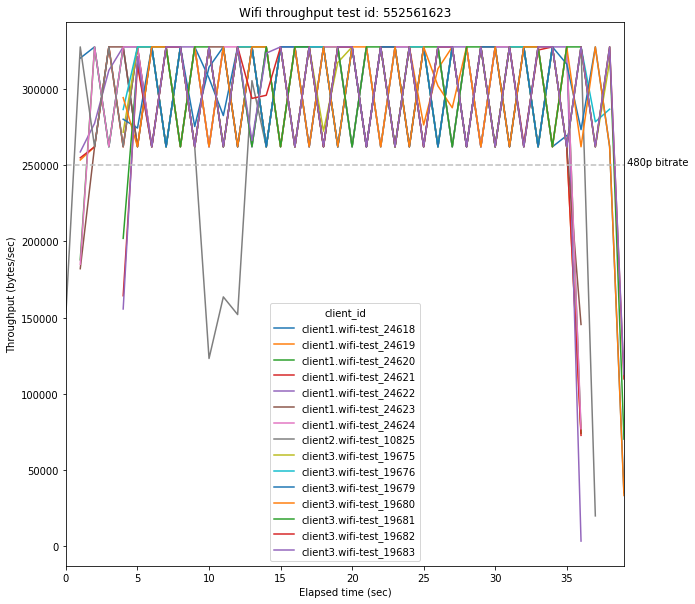

In [64]:
show_run_df_as_line_graph(summary_data,
                         "Wifi throughput test id: {0}".format(run_id))

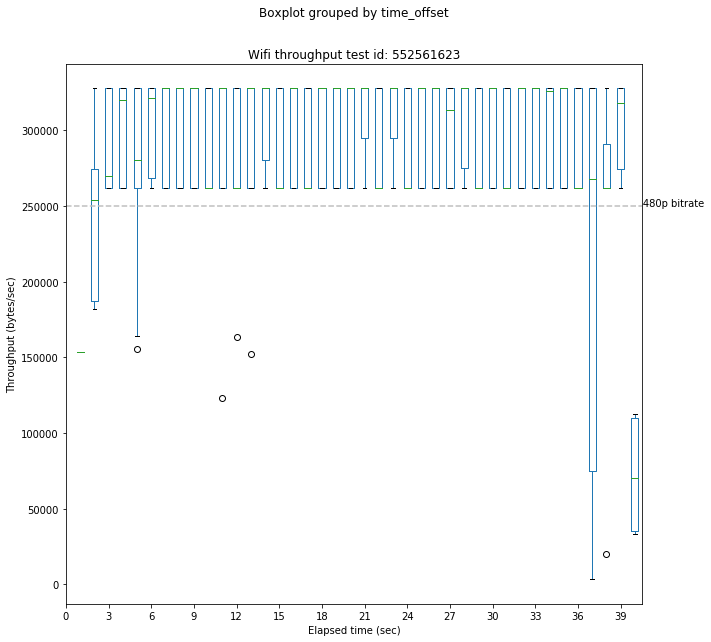

In [65]:
show_run_df_as_boxplot(summary_data,
                      "Wifi throughput test id: {0}".format(run_id))